<a href="https://colab.research.google.com/github/ardaxz99/data-glacier-week7-13/blob/main/HateSpeech_Week9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier


import os

import seaborn as sns
import re
import matplotlib.pyplot as plt
import missingno as ms
% matplotlib inline

import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [55]:
training_data = pd.read_csv('/content/drive/MyDrive/train_E6oV3lV.csv') #to read and store in panda dataframe
testing_data = pd.read_csv('/content/drive/MyDrive/test_tweets_anuFYb8.csv') #to read and store in panda dataframe

In [56]:
print("Training Set:"% training_data.columns, training_data.shape)
print("Test Set:"% testing_data.columns, testing_data.shape)


Training Set: (31962, 3)
Test Set: (17197, 2)


In [57]:
print('Train_Set -----')
print(training_data.isnull().sum())
print('Test_set -----')
print(testing_data.isnull().sum())
training_data.head()

Train_Set -----
id       0
label    0
tweet    0
dtype: int64
Test_set -----
id       0
tweet    0
dtype: int64


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [58]:
training_data['label'].value_counts() #count number of  positive and negative  tweet

0    29720
1     2242
Name: label, dtype: int64

**Cleaning**

In [59]:
import re
from sklearn.utils import resample
import nltk
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

eng_stops = set(stopwords.words("english"))
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

def cleandata(review_text):
    # remove all the special characters
    new_review_text = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", review_text) 
    # convert all letters to lower case
    words = new_review_text.lower().split()
    # remove stop words
    words = [w for w in words if not w in eng_stops]    
    # lemmatizer
    words = [lemmatizer.lemmatize(word) for word in words]
    # join all words back to text
    return (" ".join(words))

training_data['clean_tweet']=training_data['tweet'].apply(lambda x: cleandata(x))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [60]:
training_data.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunct...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit cant use cause dont offer w...
2,3,0,bihday your majesty,bihday majesty
3,4,0,#model i love u take with u all the time in ...,model love u take u time ur
4,5,0,factsguide: society now #motivation,factsguide society motivation


**EDA**

In [61]:
def createPieChartFor(t_df):
    Lst = 100*t_df.value_counts()/len(t_df)
    
    # set data for pie chart
    labels = t_df.value_counts().index.values
    sizes =  Lst 
    
    # set labels
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.2f%%', shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

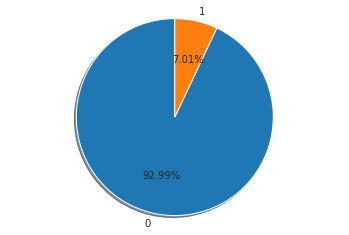

In [62]:
createPieChartFor(training_data.label)


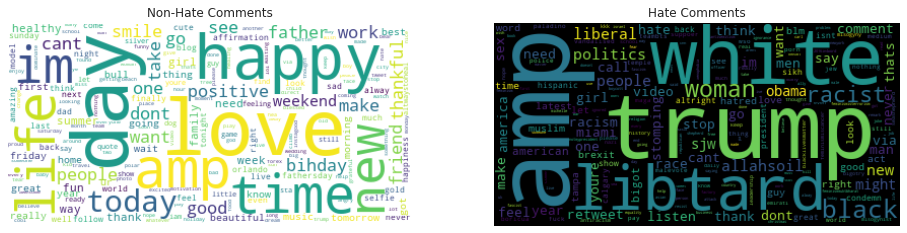

In [63]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(training_data['clean_tweet'][training_data.label == 0])
text_neg = " ".join(training_data['clean_tweet'][training_data.label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

**Test Train Split**

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

train_df, test_df =  train_test_split(training_data, test_size = 0.2, random_state = 42)


vectorizer = TfidfVectorizer()
train_tfidf_model = vectorizer.fit_transform(train_df.clean_tweet)
test_tfidf_model = vectorizer.transform(test_df.clean_tweet)
train_tfidf = pd.DataFrame(train_tfidf_model)

# **Data Imbalance Handling**

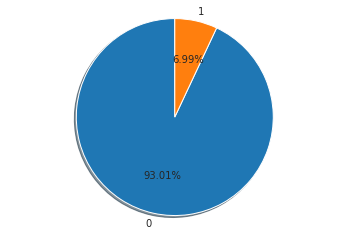

0    23783
1     1786
Name: label, dtype: int64


In [65]:
createPieChartFor(train_df.label)

print(train_df.label.value_counts())


**Downsample**

In [66]:
count_hate = train_df[train_df['label'] == 1]['clean_tweet'].count()
df_non_hate_speech = train_df[train_df['label'] == 0]
df_hate_speech = train_df[train_df['label'] == 1]
df_hate_speech_undersample = df_non_hate_speech.sample(count_hate, replace=True)
train_df_undersampled = pd.concat([df_hate_speech, df_hate_speech_undersample], axis=0)

print('Random under-sampling:')
print(train_df_undersampled['label'].value_counts())

Random under-sampling:
1    1786
0    1786
Name: label, dtype: int64


**Upsample**

In [67]:
count_non_hate = train_df[train_df['label'] == 0]['clean_tweet'].count()
df_hate_speech = train_df[train_df['label'] == 1]
df_non_hate_speech = train_df[train_df['label'] == 0]
df_hate_speech_oversample = df_hate_speech.sample(count_non_hate, replace=True)
train_df_oversampled = pd.concat([df_non_hate_speech, df_hate_speech_oversample], axis=0)

print('Random over-sampling:')
print(train_df_oversampled['label'].value_counts())

Random over-sampling:
0    23783
1    23783
Name: label, dtype: int64
